In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import layers, models
from keras.initializers import glorot_uniform
from sklearn.metrics import roc_curve, auc
import kerastuner
from kerastuner import Hyperband
import joblib

In [2]:
df = pd.read_csv('L1TRegionDump.csv')

In [3]:
df = df.sort_values(by = ['event', 'phi', 'eta'], ascending = [True,False,True])

In [4]:
df.shape

(79573536, 7)

In [5]:
df

,event,eta,phi,et,position,electron,tau
124,0,0,17,7,10,0,0
122,0,1,17,0,0,1,1
120,0,2,17,0,0,1,1
118,0,3,17,1,15,1,1
116,0,4,17,1,13,1,1
...,...,...,...,...,...,...,...
79573415,315767,9,0,0,0,1,1
79573417,315767,10,0,0,0,1,1
79573419,315767,11,0,0,0,1,1
79573421,315767,12,0,0,0,1,1


In [39]:
df_vbfh = pd.read_csv('cms-vbfh.csv')

In [28]:
df_vbfh = df_vbfh.sort_values(by = ['phi', 'eta'], ascending = [False,True])

In [40]:
df_vbfh

,eta,phi,et,position,electron,tau
0,0,0,14,1,0,1
1,0,1,14,0,0,1
2,0,2,14,0,0,1
3,0,3,14,0,0,1
4,0,4,14,1,1,1
...,...,...,...,...,...,...
251995,13,13,0,0,0,0
251996,13,14,1,11,1,1
251997,13,15,0,0,0,1
251998,13,16,0,15,1,1


In [ ]:
print(df['event'].min())
print(df['event'].max())
print(df['eta'].min())
print(df['eta'].max())
print(df['phi'].min())
print(df['phi'].max())
print(df['et'].min())
print(df['et'].max())
print(df['position'].min())
print(df['position'].max())

In [6]:
N = 10
np.random.seed(0)
event_idx = np.random.randint(low = df['event'].min(), high = df['event'].max() + 1, size = N)
dfexample = []
dfET = []
dfEleTauBits = []

for i in range(N):
    dfexample.append(df.loc[df['event'] == event_idx[i]])
    EleTauBits = []
    for index, row in dfexample[i].iterrows():
        if row['electron'] == 1 and row['tau'] == 1:
            EleTauBits.append('1,1')
        if row['electron'] == 1 and row['tau'] == 0:
            EleTauBits.append('1,0')
        if row['electron'] == 0 and row['tau'] == 1:
            EleTauBits.append('0,1')
        if row['electron'] == 0 and row['tau'] == 0:
            EleTauBits.append('0,0')
    #dfexample[i]['EleTauBits'] = EleTauBits
    dfET.append(dfexample[i].pivot('phi','eta','et'))
    #dfEleTauBits.append(dfexample[i].pivot('phi','eta','EleTauBits'))
    dfET[i] = dfET[i].sort_values('phi', ascending = False)
    #dfEleTauBits[i] = dfEleTauBits[i].sort_values('phi', ascending = False)
    

Event #: 305711
Event #: 117952
Event #: 152315
Event #: 304137
Event #: 122579
Event #: 86293
Event #: 211543
Event #: 212038
Event #: 310744
Event #: 170584


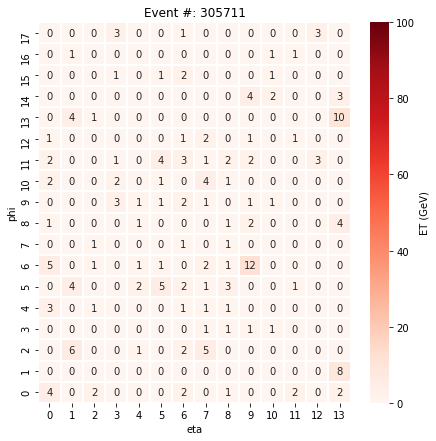

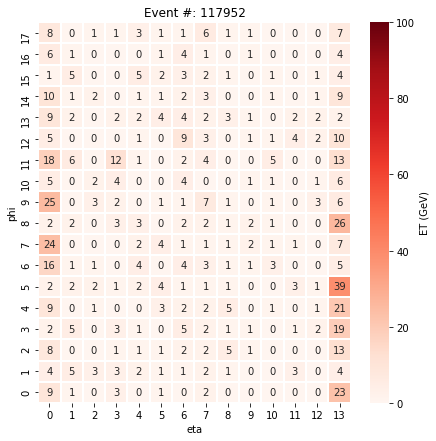

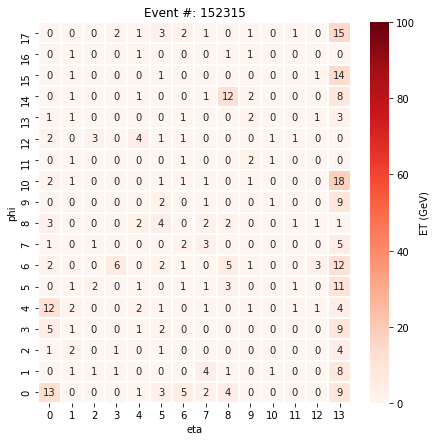

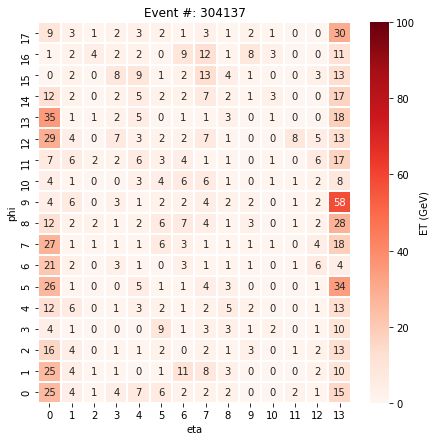

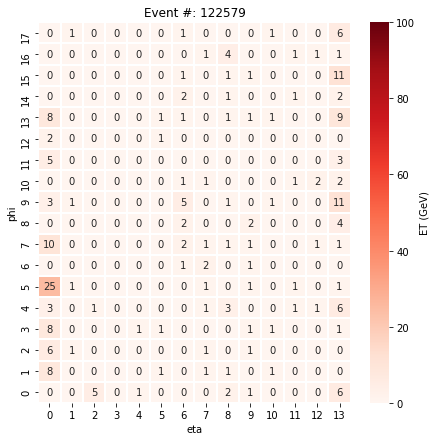

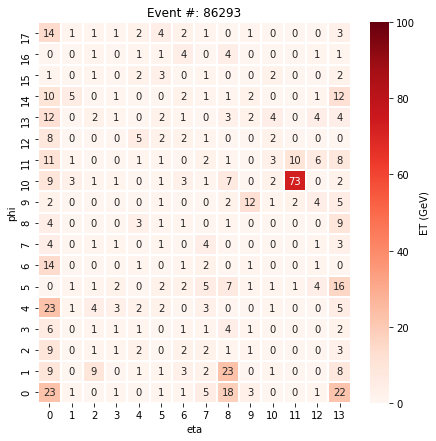

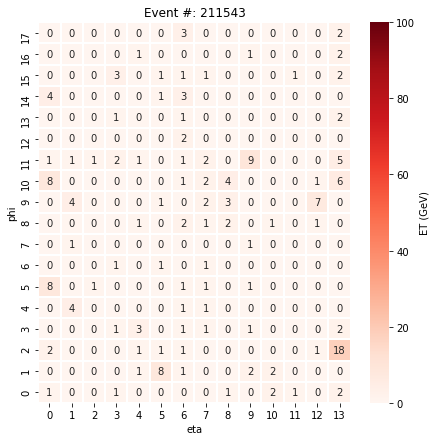

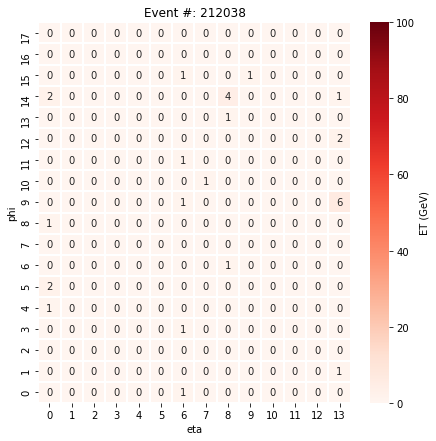

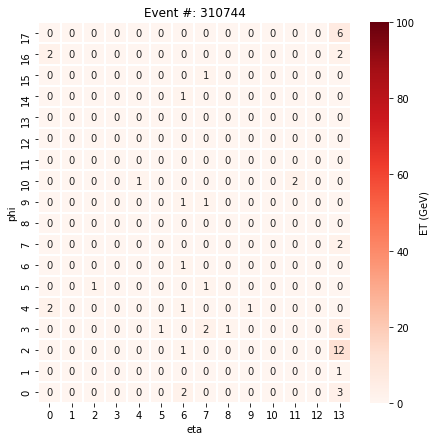

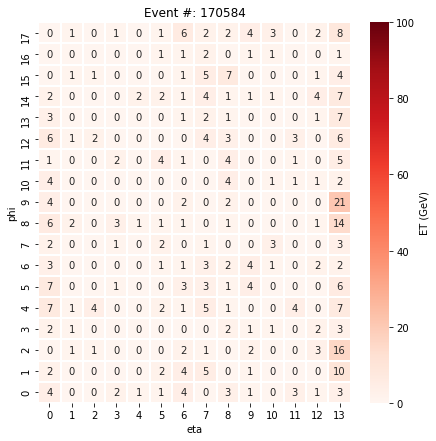

In [7]:
for i in range(N):
    fig, ax = plt.subplots(figsize = (7,7))
    ax = sns.heatmap(dfET[i], vmin = 0, vmax = 100, annot = True, linewidths = 0.1, cmap = "Reds", cbar_kws={'label': 'ET (GeV)'})
    #ax = sns.heatmap(dfET[i], vmin = 0, vmax = 100, annot = dfEleTauBits[i], fmt = '', linewidths = 0.1, cmap = "Reds", cbar_kws={'label': 'ET (GeV)'})
    ax.set_title('Event #: ' + str(event_idx[i]))
    print('Event #: ' + str(event_idx[i]))
plt.show()

In [8]:
df_reduced = df.drop(columns = ['event','position','electron','tau'])

In [41]:
df_vbfh_reduced = df_vbfh.drop(columns = ['position','electron','tau'])

In [9]:
df_reduced = df_reduced.to_numpy().reshape(315768,252,3)

In [42]:
df_vbfh_reduced = df_vbfh_reduced.to_numpy().reshape(1000,252,3)

In [43]:
df_vbfh_reduced

array([[[ 0,  0, 14],
        [ 0,  1, 14],
        [ 0,  2, 14],
        ...,
        [13, 15,  0],
        [13, 16,  0],
        [13, 17,  0]],

       [[ 0,  0,  0],
        [ 0,  1,  0],
        [ 0,  2,  0],
        ...,
        [13, 15,  0],
        [13, 16,  0],
        [13, 17,  1]],

       [[ 0,  0,  0],
        [ 0,  1,  0],
        [ 0,  2,  0],
        ...,
        [13, 15,  0],
        [13, 16,  0],
        [13, 17,  0]],

       ...,

       [[ 0,  0,  0],
        [ 0,  1,  0],
        [ 0,  2,  0],
        ...,
        [13, 15,  0],
        [13, 16,  0],
        [13, 17,  0]],

       [[ 0,  0,  0],
        [ 0,  1,  0],
        [ 0,  2,  0],
        ...,
        [13, 15,  0],
        [13, 16,  0],
        [13, 17,  0]],

       [[ 0,  0,  0],
        [ 0,  1,  2],
        [ 0,  2, 13],
        ...,
        [13, 15,  0],
        [13, 16,  0],
        [13, 17,  0]]])

In [10]:
df_sig, df_bkg = train_test_split(df_reduced, test_size = 0.5, random_state = 123)

In [11]:
#Hand-make 'signal' events by randomly assigning high ET to one of the 252 Calo regions
np.random.seed(0)
region = np.random.randint(low = 0, high = 252, size = df_sig.shape[0])
ETvalue = np.random.randint(low = 20, high = 100, size = df_sig.shape[0])
for i in range(df_sig.shape[0]):
    df_sig[i][region[i]][2] = ETvalue[i]

Signal examples:



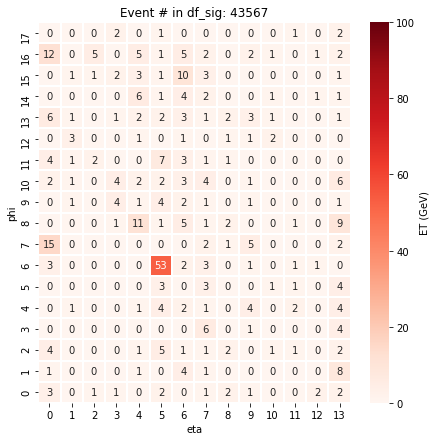

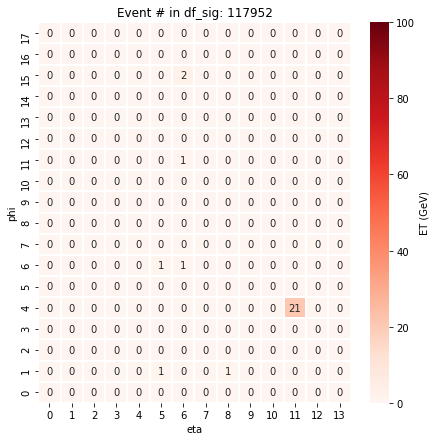

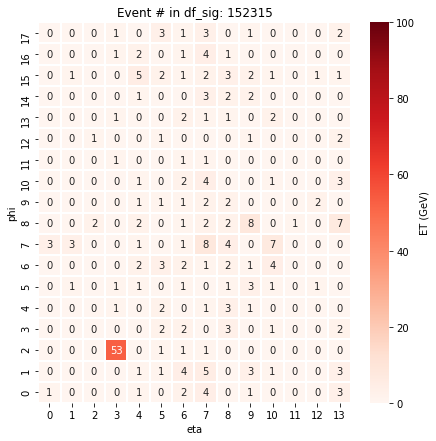

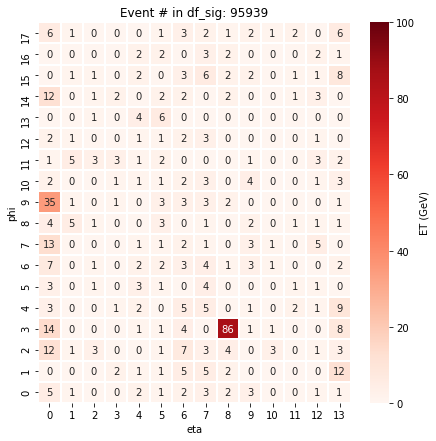

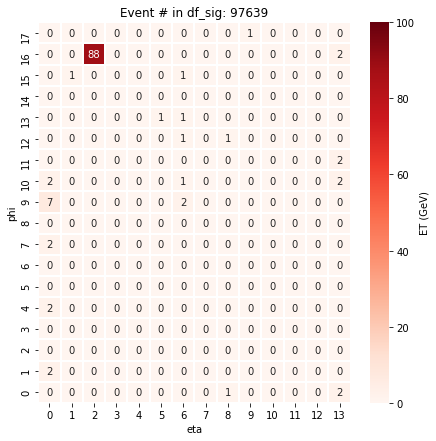

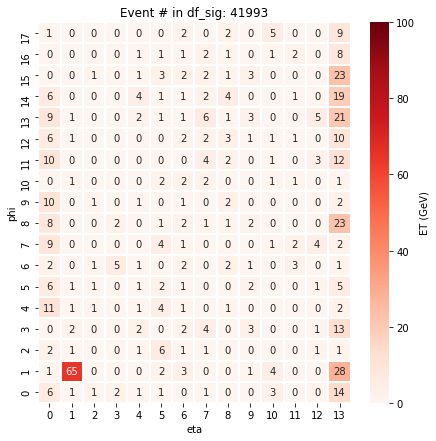

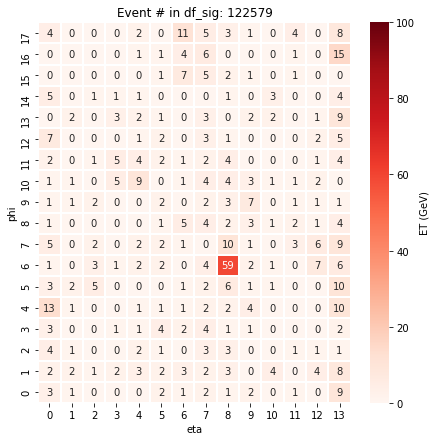

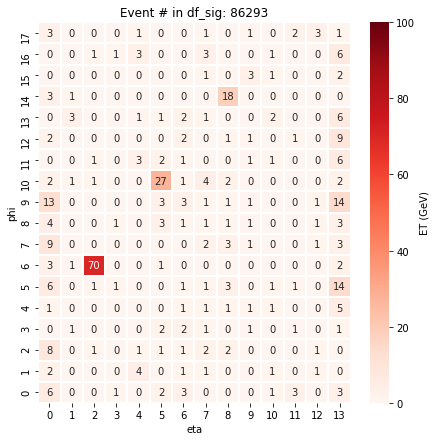

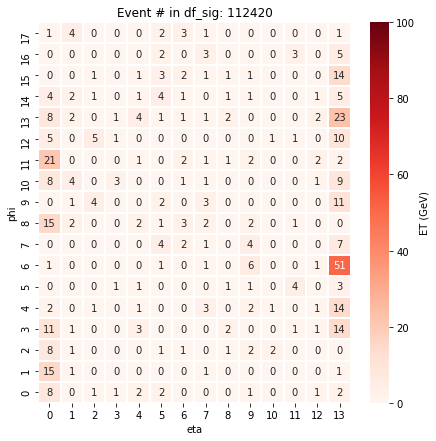

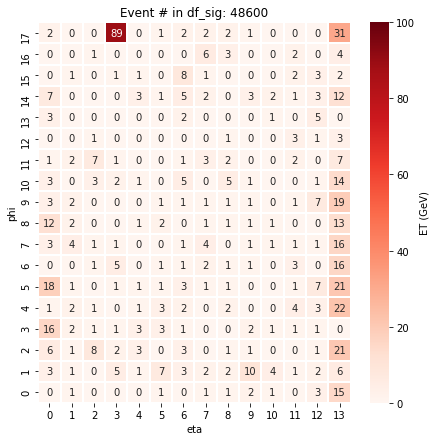

Background examples:



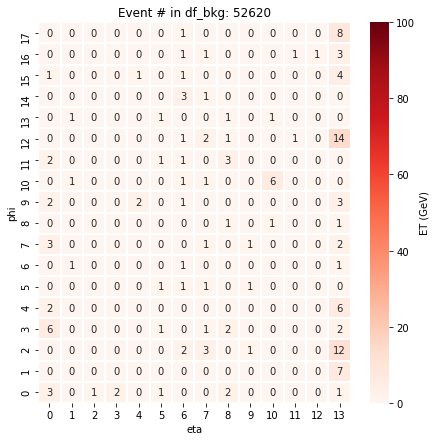

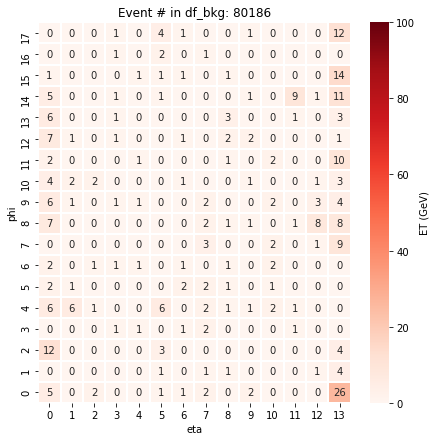

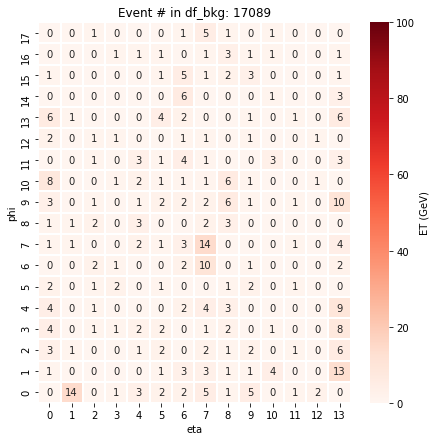

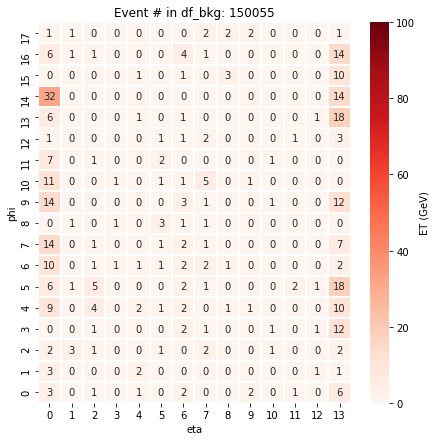

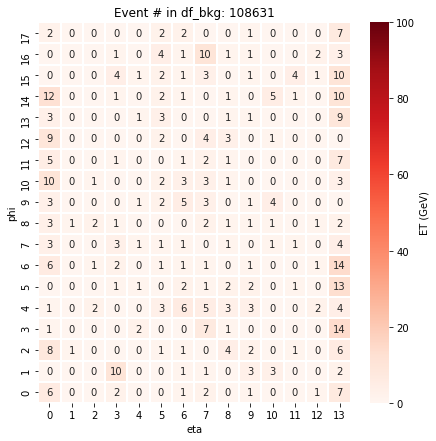

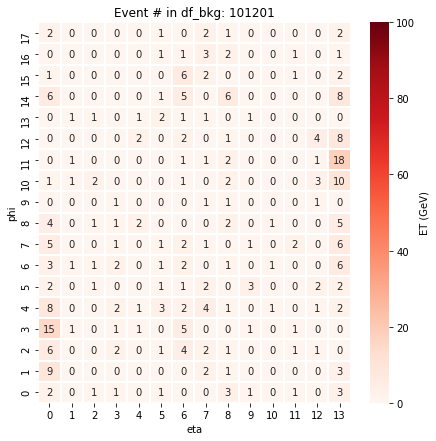

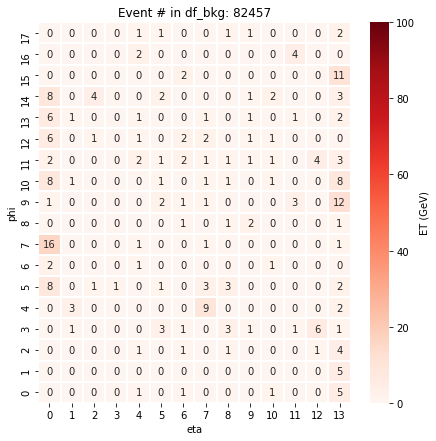

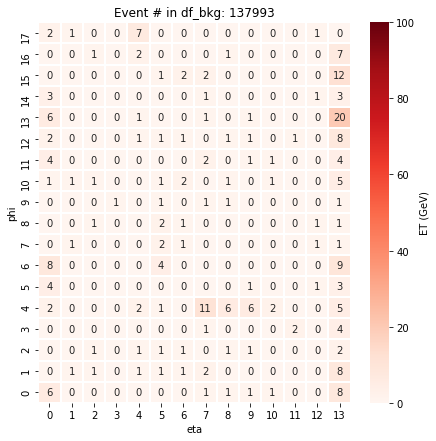

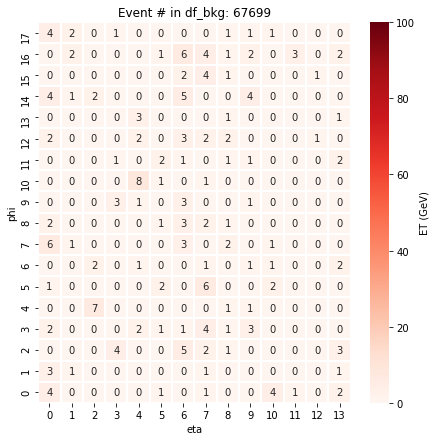

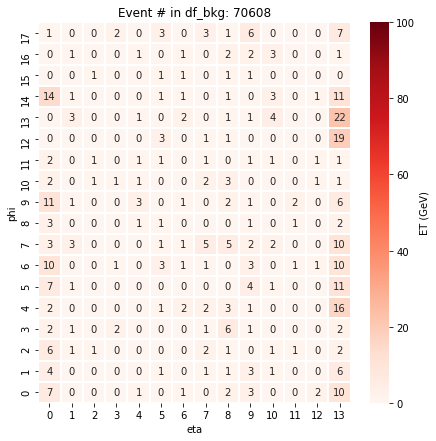

In [12]:
#Visualize and compare the Calo maps between 'signal' and 'background'
N = 10
np.random.seed(0)
sig_event_idx = np.random.randint(low = 0, high = df_sig.shape[0], size = N)
bkg_event_idx = np.random.randint(low = 0, high = df_bkg.shape[0], size = N)
sig = []
bkg = []
print('Signal examples:\n')
for i in range(N):
    sig.append(pd.DataFrame(df_sig[sig_event_idx[i]], columns = ['eta','phi','et']))
    sig[i] = sig[i].pivot('phi','eta','et')
    sig[i] = sig[i].sort_values('phi', ascending = False)
    fig, ax = plt.subplots(figsize = (7,7))
    ax = sns.heatmap(sig[i], vmin = 0, vmax = 100, annot = True, linewidths = 0.1, cmap = "Reds", cbar_kws={'label': 'ET (GeV)'})
    ax.set_title('Event # in df_sig: ' + str(sig_event_idx[i]))
plt.show()
print('Background examples:\n')
for i in range(N):
    bkg.append(pd.DataFrame(df_bkg[bkg_event_idx[i]], columns = ['eta','phi','et']))
    bkg[i] = bkg[i].pivot('phi','eta','et')
    bkg[i] = bkg[i].sort_values('phi', ascending = False)
    fig, ax = plt.subplots(figsize = (7,7))
    ax = sns.heatmap(bkg[i], vmin = 0, vmax = 100, annot = True, linewidths = 0.1, cmap = "Reds", cbar_kws={'label': 'ET (GeV)'})
    ax.set_title('Event # in df_bkg: ' + str(bkg_event_idx[i]))
plt.show()

In [13]:
sig_tag = np.ones((df_sig.shape[0], 1))
bkg_tag = np.zeros((df_bkg.shape[0], 1))

In [14]:
X = np.concatenate((df_sig, df_bkg))
Y = np.concatenate((sig_tag, bkg_tag))

In [15]:
train_ratio = 0.6
val_ratio = 0.2
test_ratio = 1 - train_ratio - val_ratio
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size = test_ratio, random_state = 123)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size = val_ratio/(val_ratio+train_ratio), random_state=123)

In [16]:
ET_mean = X_train_val[:,:,2].mean()
ET_std = X_train_val[:,:,2].std()
print("ET mean in train+val sets: " + str(ET_mean))
print("ET standard deviation in train+val sets: " + str(ET_std))
X_train[:,:,2] = (X_train[:,:,2] - ET_mean)/ET_std
X_val[:,:,2] = (X_val[:,:,2] - ET_mean)/ET_std
X_test[:,:,2] = (X_test[:,:,2] - ET_mean)/ET_std

ET mean in train+val sets: 1.342997821131456
ET standard deviation in train+val sets: 4.000118761331342


In [44]:
df_vbfh_reduced[:,:,2] = (df_vbfh_reduced[:,:,2] - ET_mean)/ET_std

In [17]:
print("\nPartition the data set into train/val/test: %.2f/%.2f/%.2f" % (train_ratio, val_ratio, test_ratio))
print("X_train.shape: " + str(X_train.shape))
print("Y_train.shape: " + str(Y_train.shape))
print("X_val.shape: " + str(X_val.shape))
print("Y_val.shape: " + str(Y_val.shape))
print("X_test.shape: " + str(X_test.shape))
print("Y_test.shape: " + str(Y_test.shape))

# print ratio of signal/background examples in each set
train_sig = np.count_nonzero(Y_train)
train_bkg = np.count_nonzero(Y_train == 0)
train_sig_perc = 100*train_sig/(train_sig+train_bkg)
train_bkg_perc = 100*train_bkg/(train_sig+train_bkg)
val_sig = np.count_nonzero(Y_val)
val_bkg = np.count_nonzero(Y_val == 0)
val_sig_perc = 100*val_sig/(val_sig+val_bkg)
val_bkg_perc = 100*val_bkg/(val_sig+val_bkg)
test_sig = np.count_nonzero(Y_test)
test_bkg = np.count_nonzero(Y_test == 0)
test_sig_perc = 100*test_sig/(test_sig+test_bkg)
test_bkg_perc = 100*test_bkg/(test_sig+test_bkg)

total_sig = train_sig + val_sig + test_sig
total_bkg = train_bkg + val_bkg + test_bkg
total_sig_perc = 100*total_sig/(total_sig+total_bkg)
total_bkg_perc = 100*total_bkg/(total_sig+total_bkg)
print("\nTotal number of sig/bkg examples: %d/%d (%.2f%%/%.2f%%)" % (total_sig, total_bkg, total_sig_perc, total_bkg_perc))

print("\nNumber of sig/bkg examples in each set:")
print("train : %d/%d (%.1f%%/%.1f%%)" % (train_sig, train_bkg, train_sig_perc, train_bkg_perc))
print("val   : %d/%d (%.1f%%/%.1f%%)" % (val_sig, val_bkg, val_sig_perc, val_bkg_perc))
print("test  : %d/%d (%.1f%%/%.1f%%)" % (test_sig, test_bkg, test_sig_perc, test_bkg_perc))


Partition the data set into train/val/test: 0.60/0.20/0.20
X_train.shape: (189460, 252, 3)
Y_train.shape: (189460, 1)
X_val.shape: (63154, 252, 3)
Y_val.shape: (63154, 1)
X_test.shape: (63154, 252, 3)
Y_test.shape: (63154, 1)

Total number of sig/bkg examples: 157884/157884 (50.00%/50.00%)

Number of sig/bkg examples in each set:
train : 94859/94601 (50.1%/49.9%)
val   : 31545/31609 (49.9%/50.1%)
test  : 31480/31674 (49.8%/50.2%)


In [18]:
X_train_reshaped = np.zeros((X_train.shape[0], 18, 14, 1))
for i in range(X_train_reshaped.shape[0]):
    for j in range(18):
        for k in range(14):
            X_train_reshaped[i][j][k][0] = X_train[i][j*14+k][2]

X_val_reshaped = np.zeros((X_val.shape[0], 18, 14, 1))
for i in range(X_val_reshaped.shape[0]):
    for j in range(18):
        for k in range(14):
            X_val_reshaped[i][j][k][0] = X_val[i][j*14+k][2]

X_test_reshaped = np.zeros((X_test.shape[0], 18, 14, 1))
for i in range(X_test_reshaped.shape[0]):
    for j in range(18):
        for k in range(14):
            X_test_reshaped[i][j][k][0] = X_test[i][j*14+k][2]

In [46]:
df_vbfh_reshaped = np.zeros((df_vbfh_reduced.shape[0], 18, 14, 1))
for i in range(df_vbfh_reshaped.shape[0]):
    for j in range(18):
        for k in range(14):
            df_vbfh_reshaped[i][j][k][0] = df_vbfh_reduced[i][(17-j)+k*18][2]

In [50]:
df_vbfh_reshaped.shape

(1000, 18, 14, 1)

In [19]:
print("X_train_reshaped.shape: " + str(X_train_reshaped.shape))
print("X_val_reshaped.shape: " + str(X_val_reshaped.shape))
print("X_test_reshaped.shape: " + str(X_test_reshaped.shape))

X_train_reshaped.shape: (189460, 18, 14, 1)
X_val_reshaped.shape: (63154, 18, 14, 1)
X_test_reshaped.shape: (63154, 18, 14, 1)


In [21]:
model = models.Sequential()
model.add(layers.Conv2D(10, (3, 3), activation = 'relu', input_shape = (18, 14, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(20, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(10, activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 12, 10)        100       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 6, 10)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 6, 4, 20)          1820      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 2, 20)          0         
_________________________________________________________________
flatten (Flatten)            (None, 120)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                1210      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

In [22]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [23]:
history = model.fit(X_train_reshaped, Y_train,
                    epochs = 5,
                    validation_data = (X_val_reshaped, Y_val),
                    batch_size = 32)

Train on 189460 samples, validate on 63154 samples
Epoch 1/5
189460/189460 [==============================] - 34s 178us/sample - loss: 0.2284 - accuracy: 0.9142 - val_loss: 0.1933 - val_accuracy: 0.9317
Epoch 2/5
189460/189460 [==============================] - 32s 171us/sample - loss: 0.1779 - accuracy: 0.9331 - val_loss: 0.1695 - val_accuracy: 0.9370
Epoch 3/5
189460/189460 [==============================] - 33s 173us/sample - loss: 0.1690 - accuracy: 0.9361 - val_loss: 0.1672 - val_accuracy: 0.9369
Epoch 4/5
189460/189460 [==============================] - 35s 187us/sample - loss: 0.1658 - accuracy: 0.9363 - val_loss: 0.1625 - val_accuracy: 0.9378
Epoch 5/5
189460/189460 [==============================] - 32s 169us/sample - loss: 0.1635 - accuracy: 0.9368 - val_loss: 0.1686 - val_accuracy: 0.9359


Text(0, 0.5, 'Accuracy (y_pred = y_true)')

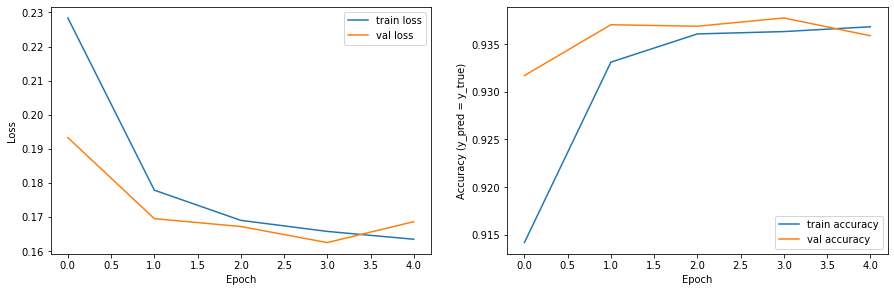

In [24]:
# plot loss vs epoch
plt.figure(figsize = (15,10))
axes = plt.subplot(2, 2, 1)
axes.plot(history.history['loss'], label = 'train loss')
axes.plot(history.history['val_loss'], label = 'val loss')
axes.legend(loc = "upper right")
axes.set_xlabel('Epoch')
axes.set_ylabel('Loss')

# plot accuracy vs epoch
axes = plt.subplot(2, 2, 2)
axes.plot(history.history['accuracy'], label = 'train accuracy')
axes.plot(history.history['val_accuracy'], label = 'val accuracy')
axes.legend(loc = "lower right")
axes.set_xlabel('Epoch')
axes.set_ylabel('Accuracy (y_pred = y_true)')

In [25]:
# test set
test_sig_number = np.count_nonzero(Y_test)
test_bkg_number = np.count_nonzero(Y_test == 0)

X_test_sig = np.zeros((test_sig_number, 18, 14, 1))
X_test_bkg = np.zeros((test_bkg_number, 18, 14, 1))

j = 0
k = 0
for i in range(Y_test.shape[0]):
    if Y_test[i,0] == 1:
        X_test_sig[j,:,:,:] = X_test_reshaped[i,:,:,:]
        j = j + 1
    else:
        X_test_bkg[k,:,:,:] = X_test_reshaped[i,:,:,:]
        k = k + 1

# train+val set
train_sig_number = np.count_nonzero(Y_train)
train_bkg_number = np.count_nonzero(Y_train == 0)

X_train_sig = np.zeros((train_sig_number, 18, 14, 1))
X_train_bkg = np.zeros((train_bkg_number, 18, 14, 1))

j = 0
k = 0
for i in range(Y_train.shape[0]):
    if Y_train[i,0] == 1:
        X_train_sig[j,:] = X_train_reshaped[i,:,:,:]
        j = j + 1
    else:
        X_train_bkg[k,:] = X_train_reshaped[i,:,:,:]
        k = k + 1

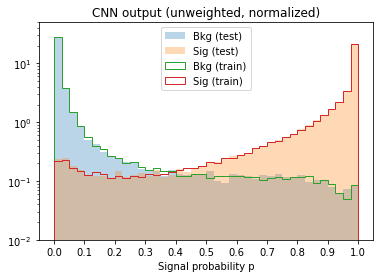

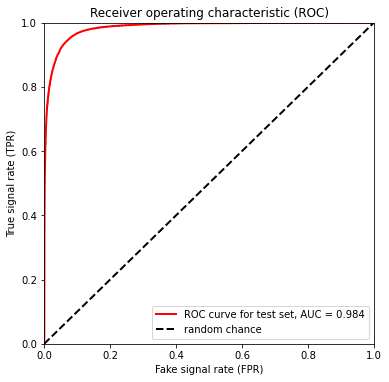

Test loss, test accuracy: [0.16837726813154782, 0.9356019]


In [26]:
#pyplot.hist(model.predict(X_test_bkg), density = 1, range = (0.0, 1.0), bins = 40, alpha = 0.3, label = 'Bkg (test)')
plt.hist(model.predict(X_test_bkg), density = 1, range = (0.0, 1.0), bins = 40, alpha = 0.3, label = 'Bkg (test)', log = True)
plt.hist(model.predict(X_test_sig), density = 1, range = (0.0, 1.0), bins = 40, alpha = 0.3, label = 'Sig (test)')
plt.hist(model.predict(X_train_bkg), density = 1, range = (0.0, 1.0), bins = 40, label = 'Bkg (train)', histtype = 'step')
plt.hist(model.predict(X_train_sig), density = 1, range = (0.0, 1.0), bins = 40, label = 'Sig (train)', histtype = 'step')
plt.legend(loc = 'upper center')
plt.title('CNN output (unweighted, normalized)')
plt.xlabel('Signal probability p')
plt.xticks(np.arange(0, 1.1, step = 0.1))
plt.ylim(1e-2,5e1)
plt.show()

# Plot ROC
plt.figure(figsize = (13,13))
Y_predict = model.predict(X_test_reshaped)
fpr, tpr, thresholds = roc_curve(Y_test, Y_predict)
roc_auc = auc(fpr, tpr)
axes = plt.subplot(2, 2, 1)
axes.plot(fpr, tpr, lw = 2, color = 'red', label = 'ROC curve for test set, AUC = %.3f' % (roc_auc))
axes.plot([0, 1], [0, 1], linestyle = '--', lw = 2, color = 'black', label = 'random chance')
axes.set_xlim([0, 1.0])
axes.set_ylim([0, 1.0])
axes.set_xlabel('Fake signal rate (FPR)')
axes.set_ylabel('True signal rate (TPR)')
axes.set_title('Receiver operating characteristic (ROC)')
axes.legend(loc = "lower right")
plt.show()

results = model.evaluate(X_test_reshaped, Y_test, verbose = 0, batch_size = 256)
print("Test loss, test accuracy:", results)

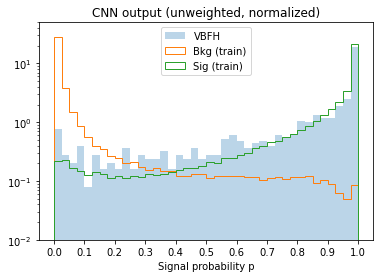

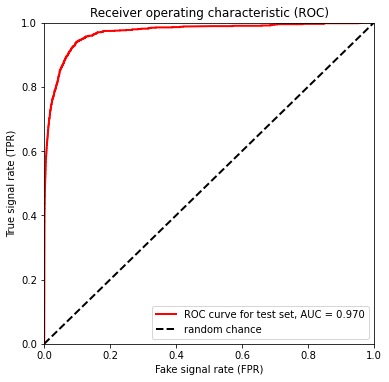

Test loss, test accuracy on VBFH: [0.3490972990989685, 0.865]


In [57]:
#pyplot.hist(model.predict(X_test_bkg), density = 1, range = (0.0, 1.0), bins = 40, alpha = 0.3, label = 'Bkg (test)')
plt.hist(model.predict(df_vbfh_reshaped), density = 1, range = (0.0, 1.0), bins = 40, alpha = 0.3, label = 'VBFH', log = True)
plt.hist(model.predict(X_train_bkg), density = 1, range = (0.0, 1.0), bins = 40, label = 'Bkg (train)', histtype = 'step')
plt.hist(model.predict(X_train_sig), density = 1, range = (0.0, 1.0), bins = 40, label = 'Sig (train)', histtype = 'step')
plt.legend(loc = 'upper center')
plt.title('CNN output (unweighted, normalized)')
plt.xlabel('Signal probability p')
plt.xticks(np.arange(0, 1.1, step = 0.1))
plt.ylim(1e-2,5e1)
plt.show()

# Plot ROC
plt.figure(figsize = (13,13))
Y_mixed_predict = model.predict(X_mixed)
fpr, tpr, thresholds = roc_curve(Y_mixed, Y_mixed_predict)
roc_auc = auc(fpr, tpr)
axes = plt.subplot(2, 2, 1)
axes.plot(fpr, tpr, lw = 2, color = 'red', label = 'ROC curve for test set, AUC = %.3f' % (roc_auc))
axes.plot([0, 1], [0, 1], linestyle = '--', lw = 2, color = 'black', label = 'random chance')
axes.set_xlim([0, 1.0])
axes.set_ylim([0, 1.0])
axes.set_xlabel('Fake signal rate (FPR)')
axes.set_ylabel('True signal rate (TPR)')
axes.set_title('Receiver operating characteristic (ROC)')
axes.legend(loc = "lower right")
plt.show()

results_vbfh = model.evaluate(df_vbfh_reshaped, Y_vbfh, verbose = 0, batch_size = 256)
print("Test loss, test accuracy on VBFH:", results_vbfh)

In [53]:
Y_vbfh = np.ones((1000,1))
Y_vbfh

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],

In [56]:
Y_test_bkg = np.zeros((X_test_bkg.shape[0],1))
Y_mixed = np.concatenate((Y_vbfh,Y_test_bkg))
X_mixed = np.concatenate((df_vbfh_reshaped,X_test_bkg))